# Unit Checked Arithmetic via Unitful.jl
### Chris Rackauckas

Units and dimensional analysis are standard tools across the sciences for checking the correctness of your equation. However, most ODE solvers only allow for the equation to be in dimensionless form, leaving it up to the user to both convert the equation to a dimensionless form, punch in the equations, and hopefully not make an error along the way.

DifferentialEquations.jl allows for one to use Unitful.jl to have unit-checked arithmetic natively in the solvers. Given the dispatch implementation of the Unitful, this has little overhead.

## Using Unitful

To use Unitful, you need to have the package installed. Then you can add units to your variables. For example:

In [2]:
using Unitful
t = 1.0u"s"

┌ Info: Precompiling Unitful [1986cc42-f94f-5a68-af5c-568840ba703d]
└ @ Base loading.jl:1186


1.0 s

Notice that `t` is a variable with units in seconds. If we make another value with seconds, they can add

In [3]:
t2 = 1.02u"s"
t+t2

2.02 s

and they can multiply:

In [4]:
t*t2

1.02 s^2

You can even do rational roots:

In [5]:
sqrt(t)

1.0 s^1/2

Many operations work. These operations will check to make sure units are correct, and will throw an error for incorrect operations:

In [6]:
t + sqrt(t)

Unitful.DimensionError: DimensionError: 1.0 s and 1.0 s^1/2 are not dimensionally compatible.

## Using Unitful with DifferentialEquations.jl

Just like with other number systems, you can choose the units for your numbers by simply specifying the units of the initial condition and the timestep. For example, to solve the linear ODE where the variable has units of Newton's and `t` is in Seconds, we would use:

In [7]:
using DifferentialEquations
f = (y,p,t) -> 0.5*y
u0 = 1.5u"N"
prob = ODEProblem(f,u0,(0.0u"s",1.0u"s"))
sol = solve(prob,Tsit5())

Unitful.DimensionError: DimensionError: N s^-1 and 0.75 N are not dimensionally compatible.

Notice that we recieved a unit mismatch error. This is correctly so! Remember that for an ODE:

$$\frac{dy}{dt} = f(t,y)$$

we must have that `f` is a rate, i.e. `f` is a change in `y` per unit time. So we need to fix the units of `f` in our example to be `N/s`. Notice that we then do not receive an error if we do the following:

In [8]:
f = (y,p,t) -> 0.5*y/3.0u"s"
prob = ODEProblem(f,u0,(0.0u"s",1.0u"s"))
sol = solve(prob,Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 3-element Array{Quantity{Float64,𝐓,Unitful.FreeUnits{(s,),𝐓,nothing}},1}:
                 0.0 s
 0.14311598261241779 s
                 1.0 s
u: 3-element Array{Quantity{Float64,𝐋*𝐌*𝐓^-2,Unitful.FreeUnits{(N,),𝐋*𝐌*𝐓^-2,nothing}},1}:
                1.5 N
 1.5362091208988309 N
 1.7720406194871123 N

This gives a a normal solution object. Notice that the values are all with the correct units:

In [9]:
print(sol[:])

Quantity{Float64,𝐋*𝐌*𝐓^-2,Unitful.FreeUnits{(N,),𝐋*𝐌*𝐓^-2,nothing}}[1.5 N, 1.53621 N, 1.77204 N]

We can plot the solution by removing the units:

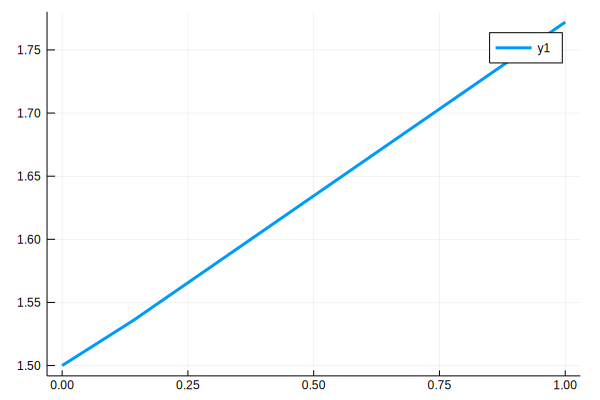

In [10]:
using Plots
gr()
plot(ustrip(sol.t),ustrip(sol[:]),lw=3)